# Analysis of board game ratings

### Business question: What characteristics of the board games determine their rating? 

**The outcome variable is the (average) ratings.**

**In our analysis we considered the following predictors:**
* Maximum playtime
* Minimum playing age
* Minimum and maximum nuber of players
* Number of users rated the board games
* Average learning and strategy complexity score
* Category (category flags were created for the most frequent categories as explained below)
* Year published

### What the code contains:
* Univariate analysis of the outcome variable and each predictor (including data cleaning, feature engineering, variable recodings).
* Bivariate analysis of the relationship between the predictors and the outcome.
* Regression analysis

### Import libraries

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
# note: for the histograms we need to upgrade the seaborn package: conda install seaborn=0.11.0

###  1. Import  data

Let's import the workfile and keep only those fields that are needed for this analysis.

In [2]:
# Import dataset 
board_games = pd.read_csv("board_games_workfile.csv", sep=';')

In [3]:
# Keep only used fields
board_games = board_games.loc[:, board_games.columns.isin([
    'game_id_base',
    'average_rating_base',
    'max_players_base',
    'max_playtime_base',
    'min_age_base',
    'min_players_base',
    'min_playtime_base',
    'users_rated_base',
    'average_learning_complexity_api',
    'average_strategy_complexity_api',
    'year_published_base',
    'category_base'
    ])]

pd.options.display.max_columns = None
board_games.head()

,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api
0,1,5,240,14,3,240,1986,"Economic,Negotiation,Political",7.66508,4498,0.000000,0.000000
1,3,4,60,10,2,30,1998,"Abstract Strategy,Medieval",7.44119,12019,0.000000,0.000000
2,11,7,45,13,2,45,1997,"Card Game,Farming,Negotiation",7.06751,28354,2.000000,2.500000
3,13,4,120,10,3,60,1995,Negotiation,7.26569,67655,2.090909,2.545455
4,18,8,120,12,2,45,1994,"Miniatures,Racing,Science Fiction",7.15355,19371,0.000000,0.000000


### 2. Analysis of the outcome variable: (average) rating

The outcome variable is the average user rating. First, let's check its distribution and the summary statistics in order to decide if any label engineering transformation is needed.

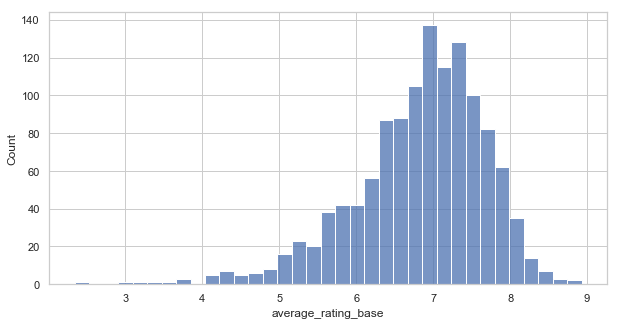

In [4]:
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
sns.histplot(board_games['average_rating_base'])
plt.show()

In [5]:
board_games.agg(
    {
        "average_rating_base": ["min", "max", "mean", "median", "std"]
    }
)

,average_rating_base
min,2.339400
max,8.931840
mean,6.826015
median,6.956030
std,0.859625


The distribution is centered a little bit below 7 scores and seems slightly left skewed with a few low ratings in the left edge of the distribution. We decided to keep these records in the dataset and no transformation was applied on the outcome.

### 3. Univariate analysis of the predictors

#### 3.1. Playing time

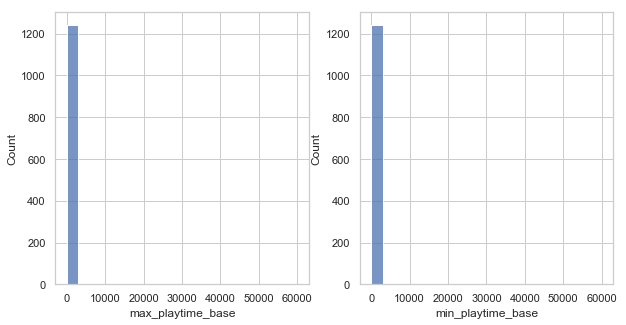

In [6]:
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2)
sns.histplot(board_games['max_playtime_base'],ax=axes[0], bins = 20)
sns.histplot(board_games['min_playtime_base'],ax=axes[1], bins = 20)
plt.show()

It looks like that there are a few outliers with extreme long playtime.
Let's investigate those board games.

In [7]:
board_games[board_games['min_playtime_base']>1000]

,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api
150,2081,2,1200,12,2,1200,1983,"American Civil War,Civil War,Post-Napoleonic,W...",7.67152,948,0.0,0.0
219,4815,10,60000,14,8,60000,1979,"Wargame,World War II",5.62887,97,5.0,3.0
250,7614,8,2880,14,1,1440,2003,"Wargame,World War II",7.61917,253,0.0,0.0


There are 3 board games where the minimum playtime is more than 1000 minutes (approximately 16.5 hours). These games look completely different from the rest of the games therefore we exclude them from out analysis.

In [8]:
board_games = board_games[board_games['min_playtime_base']<1000]

Let's check again the distributions.

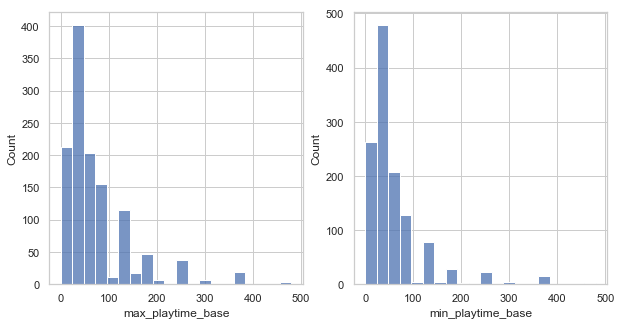

In [9]:
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2)
sns.histplot(board_games['max_playtime_base'],ax=axes[0], bins = 20)
sns.histplot(board_games['min_playtime_base'],ax=axes[1], bins = 20)
plt.show()

Let's check the summary statistics.

In [10]:
board_games.agg(
    {
        "min_playtime_base": ["min", "max", "mean", "median", "std"],
        "max_playtime_base": ["min", "max", "mean", "median", "std"],
    }
)

,min_playtime_base,max_playtime_base
min,0.000000,0.000000
max,480.000000,480.000000
mean,59.879645,73.481422
median,45.000000,50.000000
std,60.191066,69.999359


It looks that the mean playtime of the games is around one hour and it ranges between 0 and 500 minutes (about 8 hours).We can also see that the minimum playtime is 0 minutes which should stand for missing information. Let's check what proportin of the observations are impacted by the 0 playtime. In case it only affects a few observations we can substitute it with the median playtime (due to the skewed distribution).

In [11]:
bg1 = round(len(board_games[board_games['max_playtime_base']==0])/len(board_games)*100, 2)
bg2 = round(len(board_games[board_games['min_playtime_base']==0])/len(board_games)*100, 2)
print("The proportion of values with 0  in the max_playtime_base field is: "  + str(bg1) + "%")
print("The proportion of values with 0  in the min_playtime_base field is: "  + str(bg2) + "%")

The proportion of values with 0  in the max_playtime_base field is: 1.7%
The proportion of values with 0  in the min_playtime_base field is: 1.37%


The proportion is below 2% so we can substitute the zeros with the median.

In [12]:
board_games['max_playtime_base']=board_games['max_playtime_base'].replace(0,board_games['max_playtime_base'].median())
board_games['min_playtime_base']=board_games['min_playtime_base'].replace(0,board_games['min_playtime_base'].median())

board_games.agg(
    {
        "min_playtime_base": ["min", "max", "mean", "median", "std"],
        "max_playtime_base": ["min", "max", "mean", "median", "std"],
    }
)

,min_playtime_base,max_playtime_base
min,1.000000,1.000000
max,480.000000,480.000000
mean,60.497577,74.329564
median,45.000000,50.000000
std,59.802582,69.403787


There are still some very short board games with less then 10 minutes playtime but let's keep these records as they are.

In [13]:
pd.options.display.max_columns = None
print("The number of games with lower than 10 playtime is: " + str(len(board_games[board_games['min_playtime_base']<10])))
board_games[board_games['min_playtime_base']<10].head()

The number of games with lower than 10 playtime is: 16


,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api
43,258,6,30,8,2,5,1997,Card Game,5.69886,12304,1.666667,2.0
346,19841,2,5,8,2,5,2005,Abstract Strategy,6.42875,2326,0.000000,0.0
437,33468,1,5,11,1,5,2007,"Adventure,Exploration,Fighting,Horror,Print & ...",6.33544,1416,0.000000,0.0
560,65611,6,5,10,2,5,2010,"Dice,Horror,Humor,Party Game",5.22987,2280,0.000000,0.0
719,122159,6,30,8,2,5,2012,Card Game,6.13044,1875,0.000000,0.0


#### 3.2. Minimum age

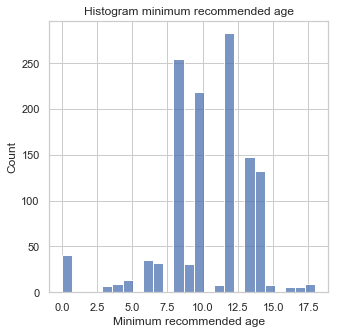

In [14]:
sns.set(rc={"figure.figsize":(5,5)}) 
sns.set_style("whitegrid")
fig = sns.histplot(board_games['min_age_base'], palette = "mako")
plt.xlabel("Minimum recommended age")
plt.ylabel("Count")
plt.title("Histogram minimum recommended age") 
plt.show(fig)

In [15]:
board_games.agg(
    {
        "min_age_base": ["min", "max", "mean", "median", "std"]
    }
)

,min_age_base
min,0.000000
max,18.000000
mean,10.305331
median,10.000000
std,3.207785


The distribution of the minimum age is centered at 10 years and is about symmetric. Again, it seems that there are observations with 0 years of minimum age and there are also some games only for adults. The zeros can be either because there is no age limit or due to missing data. Let's investigate those records.

In [16]:
print("The number of values with 0 in the min_age_base field is: "  + str(len(board_games[board_games['min_age_base']==0])))
board_games[board_games['min_age_base']==0].head()

The number of values with 0 in the min_age_base field is: 41


,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api
164,2584,4,30,0,1,30,1977,"Deduction,Electronic,Modern Warfare,Nautical",5.75361,72,2.0,2.0
191,3265,4,120,0,2,120,1998,"Card Game,Wargame,World War II",6.06774,93,0.0,0.0
390,26990,5,90,0,3,90,2007,"Economic,Industry / Manufacturing,Nautical,Tra...",7.11363,3567,3.0,4.0
428,32032,6,160,0,2,160,2007,"Economic,Electronic,Negotiation",5.06011,453,0.0,0.0
429,32149,12,60,0,3,60,2007,"Party Game,Word Game",6.90441,136,0.0,0.0


It is more likely that 0 stands for missing information so we can replace it with the median.

In [17]:
board_games['min_age_base']=board_games['min_age_base'].replace(0,board_games['min_age_base'].median())

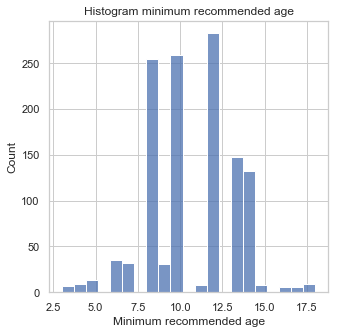

In [18]:
sns.set(rc={"figure.figsize":(5,5)}) 
sns.set_style("whitegrid")
fig = sns.histplot(board_games['min_age_base'], palette = "mako")
plt.xlabel("Minimum recommended age")
plt.ylabel("Count")
plt.title("Histogram minimum recommended age") 
plt.show(fig)

We recoded the variable to categorical with 4 levels as it seems that the distribution is concentrated at a few age intervals so grouping together these values made more sense.

In [19]:
board_games['min_age_category_base'] = pd.cut(x=board_games['min_age_base'], 
                     bins=[0, 7, 12, 17, 99],
                     labels=['0-7', 
                             '8-12',
                             '13-17',
                             '18+'])

pd.crosstab(board_games['min_age_category_base'], board_games['min_age_base'])

min_age_base,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
min_age_category_base,,,,,,,,,,,,,,,,
0-7,7,9,13,35,32,0,0,0,0,0,0,0,0,0,0,0
8-12,0,0,0,0,0,254,31,259,8,282,0,0,0,0,0,0
13-17,0,0,0,0,0,0,0,0,0,0,147,132,8,6,6,0
18+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9


Let's check the frequency by categories:

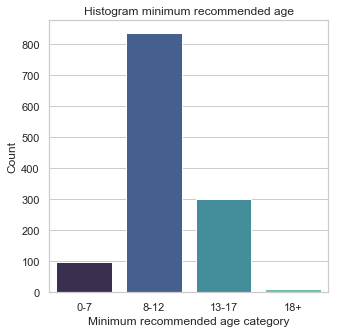

In [20]:
# Create aggregated dataset
board_games_agg = board_games.groupby('min_age_category_base').agg({'game_id_base':'count'}).rename(columns={'game_id_base':'count'})
board_games_agg.reset_index(inplace=True)

# Plot
sns.set(rc={"figure.figsize":(5,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot(x='min_age_category_base', y='count', data=board_games_agg, palette = "mako")
plt.xlabel("Minimum recommended age category")
plt.ylabel("Count")
plt.title("Histogram minimum recommended age") 
plt.show(fig)

The majority of the games have 8-17 years of minimum age recommendation.

#### 3.3. Number of players

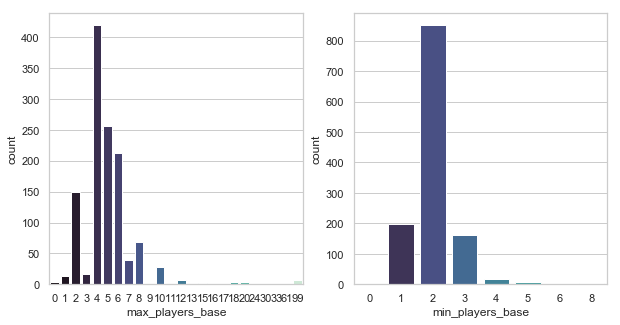

In [21]:
# Create aggregated datasets
board_games_agg1 = board_games.groupby('max_players_base').agg({'game_id_base':'count'}).rename(columns={'game_id_base':'count'})
board_games_agg1.reset_index(inplace=True)

board_games_agg2 = board_games.groupby('min_players_base').agg({'game_id_base':'count'}).rename(columns={'game_id_base':'count'})
board_games_agg2.reset_index(inplace=True)

# Plot
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2)
sns.barplot(x='max_players_base', y='count', data=board_games_agg1, palette = "mako", ax=axes[0])
sns.barplot(x='min_players_base', y='count', data=board_games_agg2, palette = "mako", ax=axes[1])
plt.show(fig)


In [22]:
board_games.agg(
    {
        "max_players_base": ["min", "max", "mean", "median", "std"],
        "min_players_base": ["min", "max", "mean", "median", "std"]
    }
)

,max_players_base,min_players_base
min,0.000000,0.000000
max,99.000000,8.000000
mean,5.515347,2.033118
median,5.000000,2.000000
std,7.648672,0.710040


There are some board games which can be plaed alone and we can see that there are a few extremes with 99 maximum players. We will replace the zeros and the outliers with the median in case of the max players.

In [23]:
board_games['max_players_base']=board_games['max_players_base'].replace(0,board_games['max_players_base'].median())
board_games['max_players_base']=board_games['max_players_base'].replace(99,board_games['max_players_base'].median())

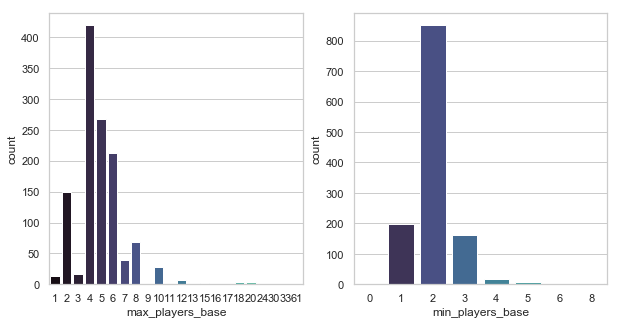

In [24]:
# Create aggregated datasets
board_games_agg1 = board_games.groupby('max_players_base').agg({'game_id_base':'count'}).rename(columns={'game_id_base':'count'})
board_games_agg1.reset_index(inplace=True)

board_games_agg2 = board_games.groupby('min_players_base').agg({'game_id_base':'count'}).rename(columns={'game_id_base':'count'})
board_games_agg2.reset_index(inplace=True)

# Plot
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2)
sns.barplot(x='max_players_base', y='count', data=board_games_agg1, palette = "mako", ax=axes[0])
sns.barplot(x='min_players_base', y='count', data=board_games_agg2, palette = "mako", ax=axes[1])
plt.show(fig)

#### 3.4. Year published

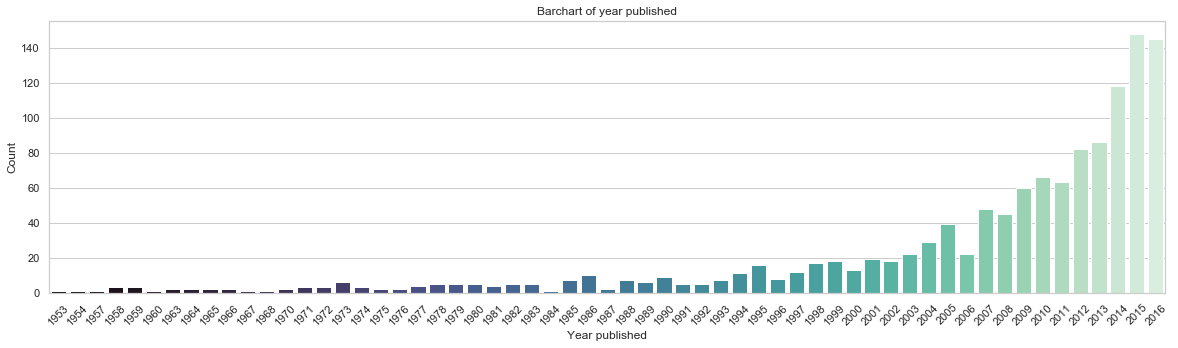

In [25]:
# Create aggregated datasets
board_games_agg = board_games.groupby('year_published_base').agg({'game_id_base':'count'}).rename(columns={'game_id_base':'count'})
board_games_agg.reset_index(inplace=True)

# Plot
sns.set(rc={"figure.figsize":(20,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot(x='year_published_base', y='count', data=board_games_agg, palette = "mako")
plt.xlabel("Year published")
plt.ylabel("Count")
plt.title("Barchart of year published") 
plt.xticks(rotation=45)
plt.show(fig)


The number of games are increasing by the year when they were published. Also, the majority of the examined games were published after 2000.

In [26]:
board_games.agg(
    {
        "year_published_base": ["min", "max"]
    }
)

,year_published_base
min,1953
max,2016


In order to avoid years with very few observations we made 10 year buckets from the publish year.

In [27]:
board_games['year_published_category_base'] = pd.cut(x=board_games['year_published_base'], 
                     bins=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020],
                     labels=['1951-1960', 
                             '1961-1970',
                             '1971-1980',
                             '1981-1990',
                             '1991-2000',
                             '2001-2010',
                             '2011-2020'])

In [28]:
pd.crosstab(board_games['year_published_category_base'], board_games['year_published_base'])

year_published_base,1953,1954,1957,1958,1959,1960,1963,1964,1965,1966,1967,1968,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
year_published_category_base,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1951-1960,1,1,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1961-1970,0,0,0,0,0,0,2,2,2,2,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1971-1980,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,6,3,2,2,4,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1981-1990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,5,1,7,10,2,7,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1991-2000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,7,11,16,8,12,17,18,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2001-2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,18,22,29,39,22,48,45,60,66,0,0,0,0,0,0
2011-2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,82,86,118,148,145


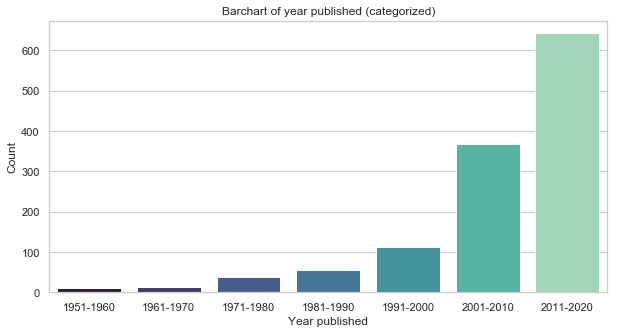

In [29]:
board_games_agg = board_games.groupby('year_published_category_base').agg({'game_id_base':'count'}).rename(columns={'game_id_base':'count'})
board_games_agg.reset_index(inplace=True)

# Plot
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.barplot(x='year_published_category_base', y='count', data=board_games_agg, palette = "mako")
plt.xlabel("Year published")
plt.ylabel("Count")
plt.title("Barchart of year published (categorized)") 
plt.show(fig)


We can see that there are a few very old board games while the majority was released after 2010.

#### 3.5. Number of users rated the games

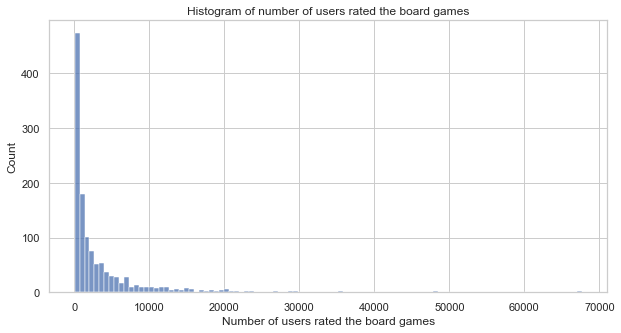

In [30]:
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.histplot(board_games['users_rated_base'], palette = "mako")
plt.xlabel("Number of users rated the board games")
plt.ylabel("Count")
plt.title("Histogram of number of users rated the board games") 
plt.show(fig)

The number of user who rated the board games is highly skewed with a few games having extreme high number of votes. We can either make categories of the variable or take the log in order to moderate the impact of the extremes. In this excercise we decided to take the logarithm of the number of users rated.

In [31]:
# Check extremes
board_games[board_games['users_rated_base']>3000].head()

,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api,min_age_category_base,year_published_category_base
0,1,5,240,14,3,240,1986,"Economic,Negotiation,Political",7.66508,4498,0.000000,0.000000,13-17,1981-1990
1,3,4,60,10,2,30,1998,"Abstract Strategy,Medieval",7.44119,12019,0.000000,0.000000,8-12,1991-2000
2,11,7,45,13,2,45,1997,"Card Game,Farming,Negotiation",7.06751,28354,2.000000,2.500000,13-17,1991-2000
3,13,4,120,10,3,60,1995,Negotiation,7.26569,67655,2.090909,2.545455,8-12,1991-2000
4,18,8,120,12,2,45,1994,"Miniatures,Racing,Science Fiction",7.15355,19371,0.000000,0.000000,8-12,1991-2000


In [32]:
# Take logarithm
board_games['users_rated_base']=board_games['users_rated_base'].replace(0,1)
board_games['users_rated_log_base'] = np.log(board_games['users_rated_base'])

Now the distribution looks closer to normal:

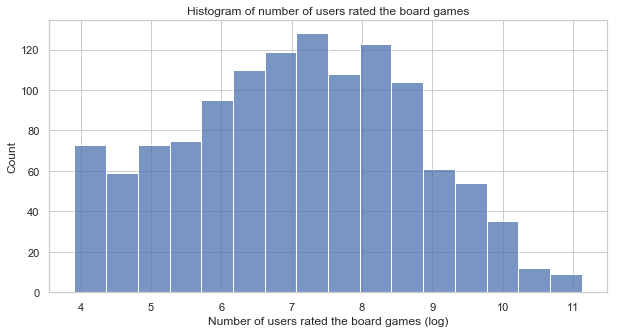

In [33]:
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.histplot(board_games['users_rated_log_base'], palette = "mako")
plt.xlabel("Number of users rated the board games (log)")
plt.ylabel("Count")
plt.title("Histogram of number of users rated the board games") 
plt.show(fig)

#### 3.6. Learning complexity

In [34]:
board_games['average_learning_complexity_api'].unique()

array([0.        , 2.        , 2.09090909, 3.        , 1.6       ,
       1.        , 5.        , 1.66666667, 1.5       , 1.33333333,
       1.88888889, 3.4       , 4.        , 2.5       , 3.5       ,
       2.33333333, 3.25      , 2.66666667, 2.75      , 2.6       ,
       1.75      , 4.71428571, 1.25      , 4.5       , 1.83333333,
       2.8       , 3.11764706, 2.44444444, 1.1       , 3.66666667,
       2.16666667])

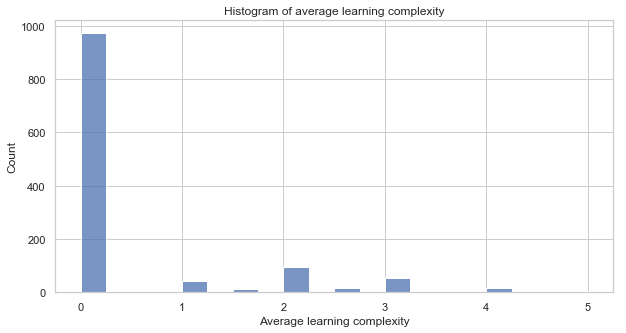

In [35]:
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.histplot(board_games['average_learning_complexity_api'], palette = "mako", bins =20)
plt.xlabel("Average learning complexity")
plt.ylabel("Count")
plt.title("Histogram of average learning complexity") 
plt.show(fig)


We could see in the workfile preparation that there were no missings so we can assume that the least complex games and games without complexity scoreas are mixed in the zero category. For the analysis we will leave this variable in its continous form instead of creating categories.


#### 3.7. Strategy complexity

In [36]:
board_games['average_strategy_complexity_api'].unique()

array([0.        , 2.5       , 2.54545455, 1.        , 2.        ,
       3.        , 2.2       , 4.5       , 1.33333333, 3.        ,
       1.5       , 3.5       , 4.        , 5.        , 2.22222222,
       2.6       , 1.66666667, 2.4       , 2.33333333, 2.25      ,
       2.58333333, 2.125     , 3.33333333, 3.2       , 2.75      ,
       3.42857143, 3.4       , 1.75      , 3.66666667, 2.66666667,
       3.33333333, 3.23529412, 4.25      , 2.83333333])

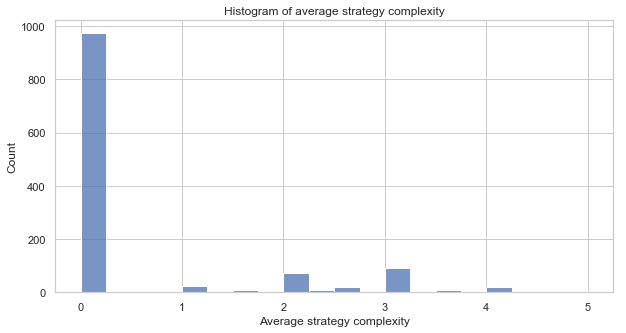

In [37]:
sns.set(rc={"figure.figsize":(10,5)}) 
sns.set_style("whitegrid")
fig = sns.histplot(board_games['average_strategy_complexity_api'], palette = "mako", bins =20)
plt.xlabel("Average strategy complexity")
plt.ylabel("Count")
plt.title("Histogram of average strategy complexity") 
plt.show(fig)

The picture is very similar to that of the the learning complexity score.

#### 3.8. Category

The category of the board games is defined as a list of categories. For further analysis we need to define dummies for each category and select the most frequent types.
For this we need to:
* Omit those records where the category is missing (there were 6 records with missing category)
* Then we need to create a corpus with the unique categories from all board games.  
* Finally, we need to transpose the created dataset and select the most frequent categories (there were about 80 unique categories so we decided to keep only the top 20 most frequent categories) and create dummies.
* Finally we can join back this dataset to the original data.

In [38]:
# Check board games categories
board_games['category_base'].head()

0       Economic,Negotiation,Political
1           Abstract Strategy,Medieval
2        Card Game,Farming,Negotiation
3                          Negotiation
4    Miniatures,Racing,Science Fiction
Name: category_base, dtype: object

**3.8. a) The first step is to remove the records with missing categories and create a new temporary dataset.**

In [39]:
# Remove nulls
board_games_temp = board_games[pd.notnull(board_games['category_base']) == True]
print(len(board_games))
print(len(board_games_temp))
board_games_temp.head()

1238
1232


,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api,min_age_category_base,year_published_category_base,users_rated_log_base
0,1,5,240,14,3,240,1986,"Economic,Negotiation,Political",7.66508,4498,0.000000,0.000000,13-17,1981-1990,8.411388
1,3,4,60,10,2,30,1998,"Abstract Strategy,Medieval",7.44119,12019,0.000000,0.000000,8-12,1991-2000,9.394244
2,11,7,45,13,2,45,1997,"Card Game,Farming,Negotiation",7.06751,28354,2.000000,2.500000,13-17,1991-2000,10.252523
3,13,4,120,10,3,60,1995,Negotiation,7.26569,67655,2.090909,2.545455,8-12,1991-2000,11.122177
4,18,8,120,12,2,45,1994,"Miniatures,Racing,Science Fiction",7.15355,19371,0.000000,0.000000,8-12,1991-2000,9.871532


**3.8. b) Then we need to clean the categories. We will concatenate the category names (eg. 'Card game' will become 'cardgame') and remove the commas so that the categories will be separated by a space.**

In [40]:
# Remove commas and split categories by word 
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove spaces and commas
    text = re.sub(' ','',text) 
    text = text.replace("'", "")
    text = re.sub(',',' ',text)
    return text

board_games_temp['category_base_clean']= board_games_temp['category_base'].apply(clean_text)
board_games_temp['category_base_clean'].head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


0      economic negotiation political
1           abstractstrategy medieval
2        cardgame farming negotiation
3                         negotiation
4    miniatures racing sciencefiction
Name: category_base_clean, dtype: object

**3.8. c) Next, we create the word corpus with the unique categories. Our dataset has 80 unique categories. Some samples are shown below.**

In [41]:
# Create word corpus
corpus = []
for ind in board_games_temp.index:
    for word in board_games_temp['category_base_clean'][ind].split():
        if word not in corpus:
            corpus.append(word)
            
print(corpus[0:10])
print(len(corpus))

['economic', 'negotiation', 'political', 'abstractstrategy', 'medieval', 'cardgame', 'farming', 'miniatures', 'racing', 'sciencefiction']
80


**3.8. d) Next, we create a dictionary where we count the number of occurances of the categories ( it is one if a particular category appears in the category list of the board game). We also convert it to dataframe.**

In [42]:
# Create dictionary with words by id
my_dict = dict.fromkeys(board_games_temp['game_id_base'])

for ind in board_games_temp.index:
    
    name = board_games_temp['game_id_base'][ind]
    col_appended = []
    
    for word in corpus: 
        
        order = len(word)
        words = "".join([word for word in board_games_temp['category_base_clean'][ind].split() if len(word) == order])
        
        col = len(re.findall(word, words))
        col_appended.append(col)
        
    my_dict[name] = col_appended

    # Create dataframe
dummies_pre = pd.DataFrame(my_dict)
dummies_pre.head()

,1,3,11,13,18,19,30,41,42,44,46,47,50,51,54,71,72,88,93,103,116,118,120,121,124,130,134,147,150,153,157,168,170,172,173,181,199,220,221,242,243,249,257,258,278,290,334,339,340,359,361,372,380,386,394,398,421,422,423,427,431,432,438,441,443,463,475,483,485,494,503,526,530,552,559,562,590,594,631,633,675,681,684,699,706,760,770,804,822,859,864,875,891,903,908,925,943,980,986,987,1111,1157,1159,1198,1218,1219,1231,1234,1258,1261,1270,1293,1295,1298,1301,1339,1353,1382,1403,1447,1465,1472,1489,1493,1498,1515,1561,1574,1588,1608,1645,1663,1669,1672,1679,1713,1717,1760,1768,1824,1829,1860,1901,1915,1927,1931,1932,1982,2060,2076,2165,2223,2250,2318,2346,2381,2452,2453,2487,2511,2518,2536,2581,2584,2651,2655,2667,2679,2749,2750,2767,2778,2799,2802,2808,2817,2818,2842,2854,2922,2929,2946,2987,3042,3061,3076,3085,3093,3190,3226,3265,3414,3421,3522,3570,3632,3699,3730,3737,3804,3883,3935,3955,4052,4095,4098,4099,4127,4143,4205,4324,4374,4396,4453,4454,4491,4636,4642,4831,4975,5015,5129,5166,5339,5404,5472,5770,5782,5894,5895,5996,6068,6339,6352,6381,6411,6472,6532,6608,6714,6738,6766,6810,6830,6891,6958,7180,7457,7688,7710,7805,7854,7972,8041,8079,8098,8125,8217,8222,8229,8273,8374,8481,8553,8598,8730,8804,8924,8970,8989,9108,9209,9440,9446,9514,9625,9725,9938,10383,10547,10630,10681,10712,11057,11231,11394,11532,11542,11634,11825,11971,12002,12005,12333,12589,12601,12750,12761,12942,12962,13004,13122,13823,13875,14254,14452,14634,14701,14996,15062,15278,15364,15511,15512,15817,15954,16496,16986,16992,17025,17053,17132,17133,17329,17392,17405,17451,17820,17851,17970,18041,18100,18333,18485,18602,18866,18895,18946,19351,19370,19600,19616,19764,19841,19857,19918,19947,19948,19999,20100,20432,20437,21050,21123,21241,21566,21882,22345,22378,22551,22825,22864,22950,23010,23094,23263,23373,23375,23418,23671,23890,24000,24068,24141,24181,24304,24310,24508,24764,25292,25417,25568,25613,25669,25821,26566,26859,26990,26997,27356,27364,27588,27708,27710,27746,27833,27848,27961,27970,28023,28086,28143,28620,28720,28907,29109,29126,29368,29383,29387,29613,29676,29839,30324,30380,30539,30549,30645,31105,31260,31481,31594,31627,31730,31999,32032,32149,32165,32424,32441,32495,32666,33160,33451,33468,33604,33967,34119,34127,34219,34297,34635,34744,34887,35023,35254,35285,35497,35505,35570,35677,36218,36235,36345,36400,36424,36661,36739,36946,37046,37141,37196,37198,37498,37615,37628,37904,38054,38343,38355,38364,38453,38499,38506,38531,38765,38996,39080,39206,39463,39798,39856,39938,39953,40209,40251,40258,40347,40354,40398,40603,40628,40692,40760,40770,40793,40834,41002,41010,41095,41114,41186,41372,41429,41627,41749,41916,42368,42448,42452,42929,43015,43136,43152,43307,43365,43443,43570,45315,45986,46213,47185,48726,48979,50381,50750,53953,54043,54137,54138,54998,55222,55600,55690,55705,55829,56342,56692,57163,58696,59060,60153,60435,61692,62219,62478,62871,63067,63268,63628,63706,63759,63888,64875,65244,65282,65515,65611,65781,65814,65901,65907,66171,66188,66356,66362,66589,66837,67601,67877,68186,68425,68448,68858,69789,70149,70323,70512,70919,71402,71671,71676,71973,72125,72225,72287,72321,72991,73313,73369,73439,73538,73761,75448,75828,76417,76436,77130,77423,79828,82168,82222,82421,83667,84671,84876,85005,85256,85563,86073,86156,88253,88827,88922,89409,90419,90730,91080,91312,91534,91620,92319,92415,93260,93287,93522,93819,94362,94389,95234,95527,96188,96260,96713,96792,96913,97207,97273,97842,97903,97915,98085,98229,98351,98778,99081,99097,99120,99791,99935,100423,100901,101785,102104,102151,102181,102435,102548,102652,102680,102794,103649,103660,103670,103883,103886,104006,104363,104655,105037,105551,107529,108044,108722,108745,108906,109125,109291,109779,110327,111105,111124,111341,111799,112373,112869,113289,113294,113873,113997,114667,114991,115105,116954,117823,117908,117959,118048,118174,118536,118776,119407,119506,119591,119788,120447,120523,120677,121288,121297,121408,121410,121787,121921,121958,121995,122159,122298,122515,122522,123096,1

**3.8. e) Last we need to transpose the matrix and crete the final dataset with the dummies.**

In [43]:
# Transpose df
dummies_transposed = np.transpose(dummies_pre)

# Assign filnames as column names
dummies_transposed.columns = corpus

# Add index  to columns
dummies_transposed.reset_index(inplace=True)
dummies_transposed = dummies_transposed.rename(columns = {'index':'game_id_base'})
dummies_transposed.columns += '_d'

pd.set_option("display.max_columns", None)
dummies_transposed.head()

,game_id_base_d,economic_d,negotiation_d,political_d,abstractstrategy_d,medieval_d,cardgame_d,farming_d,miniatures_d,racing_d,sciencefiction_d,americanwest_d,bluffing_d,citybuilding_d,adventure_d,electronic_d,exploration_d,fantasy_d,fighting_d,dice_d,ancient_d,civilization_d,territorybuilding_d,renaissance_d,maze_d,puzzle_d,real-time_d,humor_d,novel-based_d,prehistoric_d,trains_d,transportation_d,nautical_d,industry/manufacturing_d,action/dexterity_d,childrensgame_d,partygame_d,sports_d,mafia_d,wargame_d,civilwar_d,worldwarii_d,murder/mystery_d,wordgame_d,animals_d,deduction_d,pirates_d,arabian_d,travel_d,collectiblecomponents_d,post-napoleonic_d,ageofreason_d,trivia_d,horror_d,movies/tv/radiotheme_d,print&play_d,memory_d,americanindianwars_d,napoleonic_d,americancivilwar_d,aviation/flight_d,spies/secretagents_d,modernwarfare_d,comicbook/strip_d,number_d,medical_d,mythology_d,educational_d,math_d,environmental_d,americanrevolutionarywar_d,music_d,videogametheme_d,religious_d,mature/adult_d,spaceexploration_d,worldwari_d,zombies_d,book_d,vietnamwar_d,expansionforbase-game_d
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**3.8. f) Now we can join it back to the main dataset.**

In [44]:
# Join datasets
board_games = pd.merge(left = board_games, 
      right = dummies_transposed, 
      how = "left",
      left_on = "game_id_base",
      right_on = "game_id_base_d")
board_games.head()

,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api,min_age_category_base,year_published_category_base,users_rated_log_base,game_id_base_d,economic_d,negotiation_d,political_d,abstractstrategy_d,medieval_d,cardgame_d,farming_d,miniatures_d,racing_d,sciencefiction_d,americanwest_d,bluffing_d,citybuilding_d,adventure_d,electronic_d,exploration_d,fantasy_d,fighting_d,dice_d,ancient_d,civilization_d,territorybuilding_d,renaissance_d,maze_d,puzzle_d,real-time_d,humor_d,novel-based_d,prehistoric_d,trains_d,transportation_d,nautical_d,industry/manufacturing_d,action/dexterity_d,childrensgame_d,partygame_d,sports_d,mafia_d,wargame_d,civilwar_d,worldwarii_d,murder/mystery_d,wordgame_d,animals_d,deduction_d,pirates_d,arabian_d,travel_d,collectiblecomponents_d,post-napoleonic_d,ageofreason_d,trivia_d,horror_d,movies/tv/radiotheme_d,print&play_d,memory_d,americanindianwars_d,napoleonic_d,americancivilwar_d,aviation/flight_d,spies/secretagents_d,modernwarfare_d,comicbook/strip_d,number_d,medical_d,mythology_d,educational_d,math_d,environmental_d,americanrevolutionarywar_d,music_d,videogametheme_d,religious_d,mature/adult_d,spaceexploration_d,worldwari_d,zombies_d,book_d,vietnamwar_d,expansionforbase-game_d
0,1,5,240,14,3,240,1986,"Economic,Negotiation,Political",7.66508,4498,0.000000,0.000000,13-17,1981-1990,8.411388,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,4,60,10,2,30,1998,"Abstract Strategy,Medieval",7.44119,12019,0.000000,0.000000,8-12,1991-2000,9.394244,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,7,45,13,2,45,1997,"Card Game,Farming,Negotiation",7.06751,28354,2.000000,2.500000,13-17,1991-2000,10.252523,11.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,4,120,10,3,60,1995,Negotiation,7.26569,67655,2.090909,2.545455,8-12,1991-2000,11.122177,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,8,120,12,2,45,1994,"Miniatures,Racing,Science Fiction",7.15355,19371,0.000000,0.000000,8-12,1991-2000,9.871532,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**3.8. g) Let's check the most frequent categories.**

In [45]:
dummies = board_games[board_games.columns[pd.Series(board_games.columns).str.endswith('_d')]].sum().sort_values(ascending = False).head(21)
dummies = pd.DataFrame(dummies)
dummies.rename(columns={'0': 'count'})
dummies.reset_index(inplace=True)
dummies = dummies.rename(columns = {'index':'dummy', 0: 'count'})
dummies = dummies[dummies['dummy'] != 'game_id_base_d']
dummies

,dummy,count
1,cardgame_d,397.0
2,economic_d,206.0
3,fantasy_d,172.0
4,sciencefiction_d,134.0
5,fighting_d,120.0
6,wargame_d,115.0
7,dice_d,113.0
8,partygame_d,96.0
9,bluffing_d,91.0
10,medieval_d,80.0


**3.8. h) The top 20 most frequent categories are the following:**

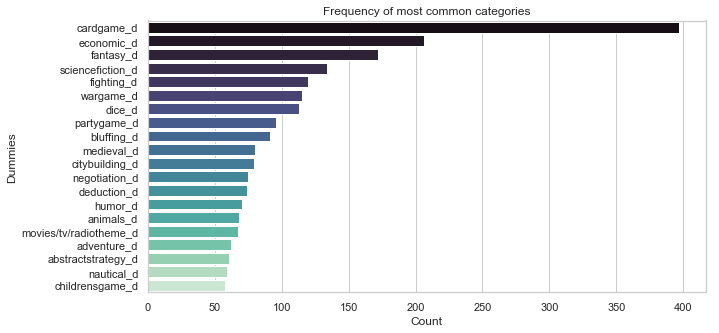

In [46]:
fig = sns.barplot(y='dummy', x='count', data=dummies, palette = "mako")
plt.xlabel("Count")
plt.ylabel("Dummies")
plt.title("Frequency of most common categories") 
plt.show(fig)

**3.8. i) We will remove those category dummies that are not among the most frequent dummies.**

In [47]:
# Get all dummies minus the most frequents
all_dummies = board_games[board_games.columns[pd.Series(board_games.columns).str.endswith('_d')]].columns
keep_dummies = dummies['dummy'].unique()
remove_dummies = list(set(all_dummies) - set(keep_dummies))
# remove_dummies

In [48]:
board_games = board_games.drop(columns=remove_dummies)
board_games.head()

,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api,min_age_category_base,year_published_category_base,users_rated_log_base,economic_d,negotiation_d,abstractstrategy_d,medieval_d,cardgame_d,sciencefiction_d,bluffing_d,citybuilding_d,adventure_d,fantasy_d,fighting_d,dice_d,humor_d,nautical_d,childrensgame_d,partygame_d,wargame_d,animals_d,deduction_d,movies/tv/radiotheme_d
0,1,5,240,14,3,240,1986,"Economic,Negotiation,Political",7.66508,4498,0.000000,0.000000,13-17,1981-1990,8.411388,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,4,60,10,2,30,1998,"Abstract Strategy,Medieval",7.44119,12019,0.000000,0.000000,8-12,1991-2000,9.394244,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,7,45,13,2,45,1997,"Card Game,Farming,Negotiation",7.06751,28354,2.000000,2.500000,13-17,1991-2000,10.252523,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,4,120,10,3,60,1995,Negotiation,7.26569,67655,2.090909,2.545455,8-12,1991-2000,11.122177,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,8,120,12,2,45,1994,"Miniatures,Racing,Science Fiction",7.15355,19371,0.000000,0.000000,8-12,1991-2000,9.871532,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Bivariate analysis 

We started the analysis of the relationship with the outcome by keeping only the relevant fields. 

In [49]:
# List of predictors
board_games_short = board_games.loc[:, board_games.columns.isin([
    'average_rating_base',
    'max_playtime_base', 
    #'min_playtime_base',
    #'min_age_base',
    'min_age_category_base',
    'max_players_base',
    'min_players_base',
    'users_rated_log_base',
    'average_learning_complexity_api',
    'average_strategy_complexity_api',
    'year_published_category_base',

    'cardgame_d',
    'economic_d',
    'fantasy_d',
    'sciencefiction_d',
    'fighting_d',
    'wargame_d',
    'dice_d',
    'partygame_d',
    'bluffing_d',
    'medieval_d',
    'citybuilding_d',
    'negotiation_d',
    'deduction_d',
    'humor_d',
    'animals_d',
    'amovies/tv/radiotheme_d',
    'adventure_d',
    'abstractstrategy_d',
    'nautical_d',
    'childrensgame_d'
    ])]

There were 6 records with missing category dummies and no other predictors have missings. For the regression analyis we need to eliminate these missings therefore we replaced them with zeros.

In [50]:
# Check number of missings 
board_games_short.isnull().sum()

max_players_base                   0
max_playtime_base                  0
min_players_base                   0
average_rating_base                0
average_learning_complexity_api    0
average_strategy_complexity_api    0
min_age_category_base              0
year_published_category_base       0
users_rated_log_base               0
economic_d                         6
negotiation_d                      6
abstractstrategy_d                 6
medieval_d                         6
cardgame_d                         6
sciencefiction_d                   6
bluffing_d                         6
citybuilding_d                     6
adventure_d                        6
fantasy_d                          6
fighting_d                         6
dice_d                             6
humor_d                            6
nautical_d                         6
childrensgame_d                    6
partygame_d                        6
wargame_d                          6
animals_d                          6
d

In [51]:
# Replace nulls with 0
dummies = board_games_short[board_games_short.columns[pd.Series(board_games_short.columns).str.endswith('_d')]].columns.values.tolist()
dummies
for x in dummies:   
    board_games_short[x] = board_games_short[x].fillna(0)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### 4.1. Continous predictors

In case of the continous predictors we examined the scatterplot and the correlation matrix of the outcome and each predictor.

The main findings are the following:
* The ratings are in positive relationship with the maximum playtime: the higher the playtime is the higher expect.
* The ratings decrease with the minimum number of players: the higher the number of the minimum number f players required for the game the lower ratings we can expect. Somewhat similar pattern can be observed in case of the maximum number of players.
* Regarding the level of strategy and learning complexity, we can again see an increasing pattern.
* Finally, board games with more user ratings are expected to have higher ratings.

In [52]:
predictors = board_games_short.loc[:, board_games_short.columns.isin([
    'max_playtime_base', 
    'max_players_base',
    'min_players_base',
    'users_rated_log_base',
    'average_learning_complexity_api',
    'average_strategy_complexity_api',
    ])].columns.values.tolist()
predictors


['max_players_base',
 'max_playtime_base',
 'min_players_base',
 'average_learning_complexity_api',
 'average_strategy_complexity_api',
 'users_rated_log_base']

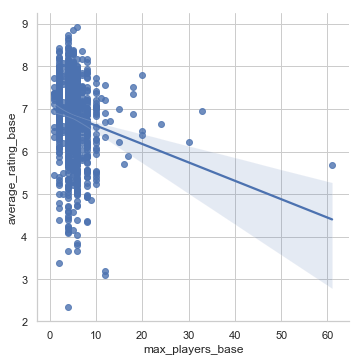

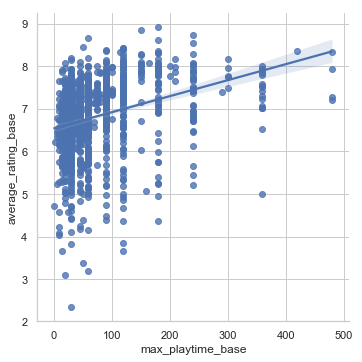

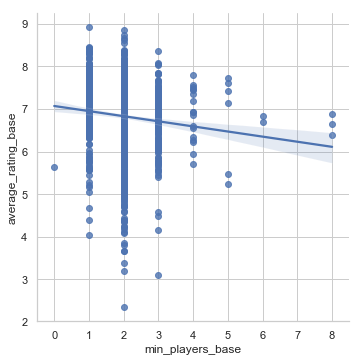

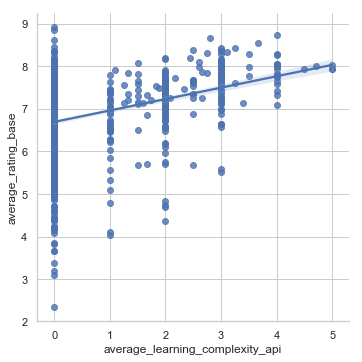

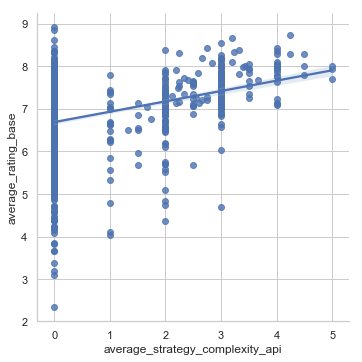

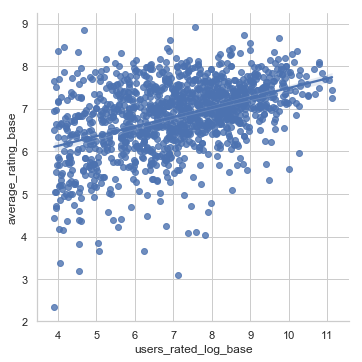

In [53]:
for x in predictors:   
    sns.lmplot(data=board_games_short, x=x,y='average_rating_base')

From the correlation matrix we can see that the number of users who rated the board games are in the strongest correlation with the ratings. The complexity scores and the maxiumum playtime have also above 30% correlation with the ratings. 

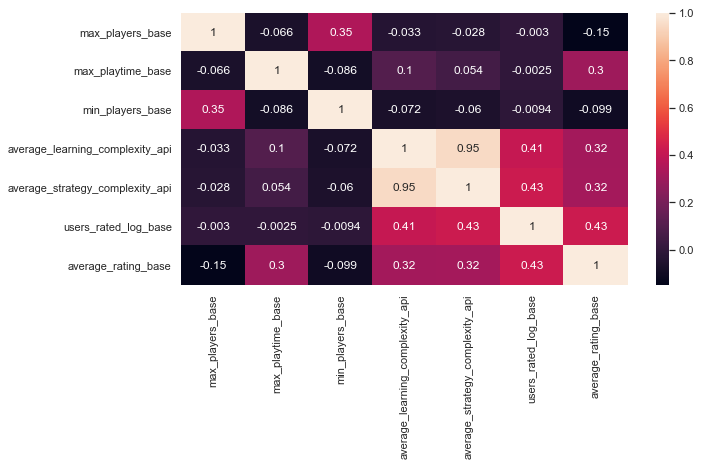

In [54]:
# Correlation matrix
corr = board_games_short.filter(predictors)
corr['average_rating_base'] = board_games_short['average_rating_base']

corrMatrix = corr.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### 4.2. Categorical predictors

In case of the categorical variables we examined the distribution of the outcome by the categories and visualized the relationship with boxplots.

The main findings are the following:
* The average rating increases with the minimum age. Exception to this are the board games recommended for adult audiance where there were very limited number of cases.
* Ratings seem to incrase with the publish date: the median rating is above 6.5 in the post 2000 period.
* Regarding the category dummies, the games for children ('childrensgame') and the category 'humor' seems to have the strongest discriminatory power.

In [55]:
# Cretae list of categorical variables
dummies = board_games_short[board_games_short.columns[pd.Series(board_games_short.columns).str.endswith('_d')]].columns.values.tolist()
categorical = ['min_age_category_base', 'year_published_category_base']
categorical = categorical + dummies
categorical

['min_age_category_base',
 'year_published_category_base',
 'economic_d',
 'negotiation_d',
 'abstractstrategy_d',
 'medieval_d',
 'cardgame_d',
 'sciencefiction_d',
 'bluffing_d',
 'citybuilding_d',
 'adventure_d',
 'fantasy_d',
 'fighting_d',
 'dice_d',
 'humor_d',
 'nautical_d',
 'childrensgame_d',
 'partygame_d',
 'wargame_d',
 'animals_d',
 'deduction_d']

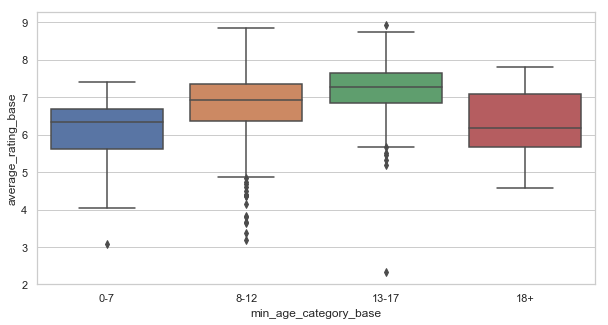

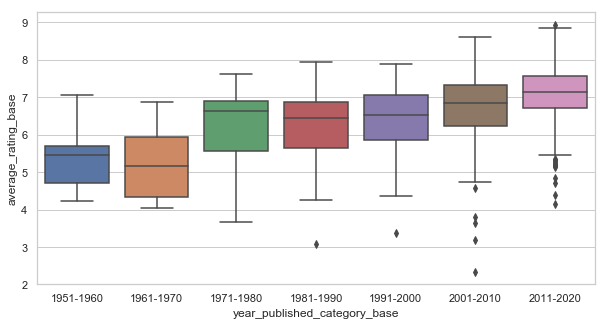

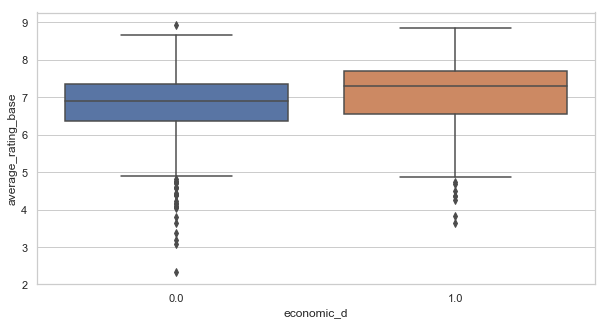

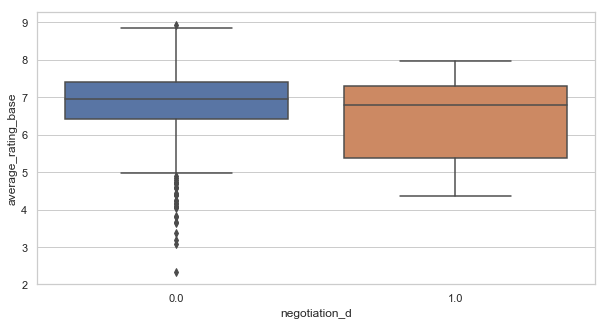

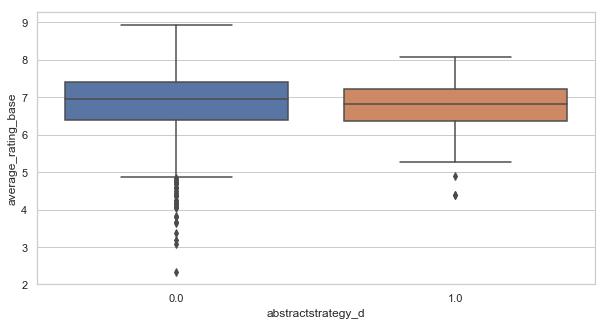

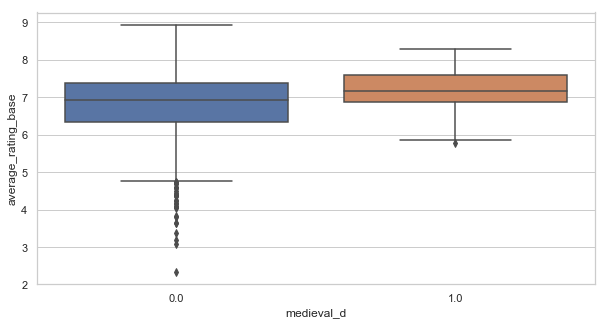

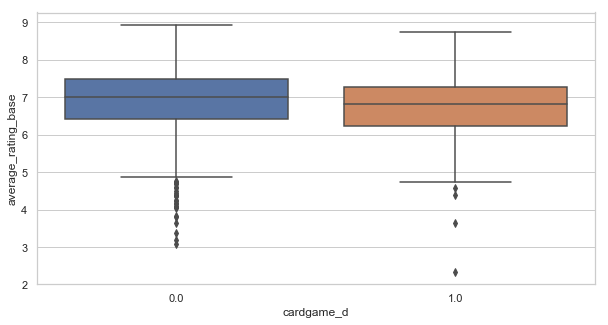

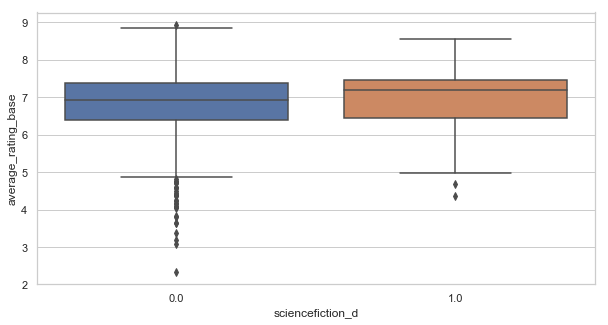

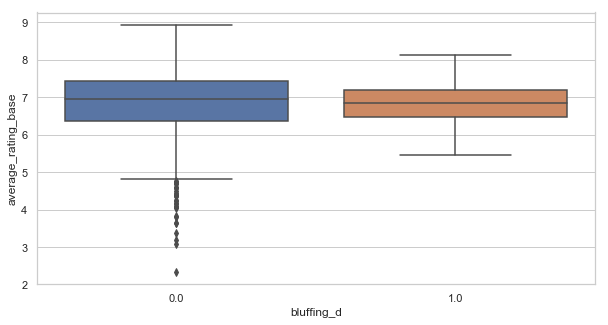

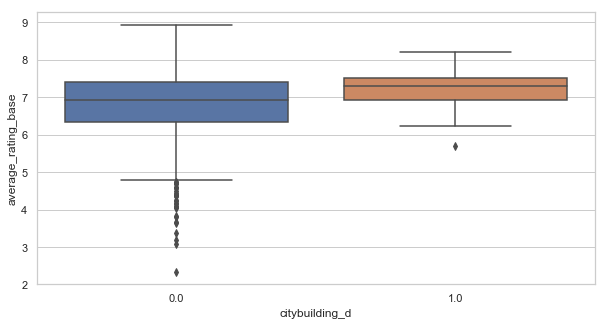

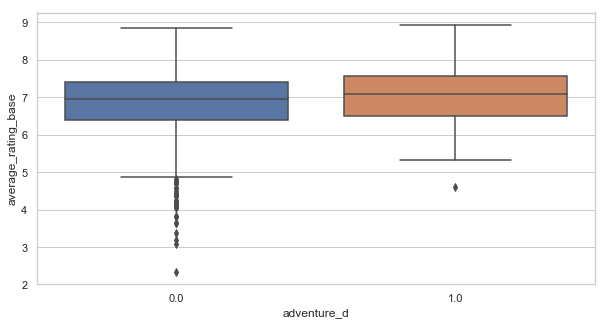

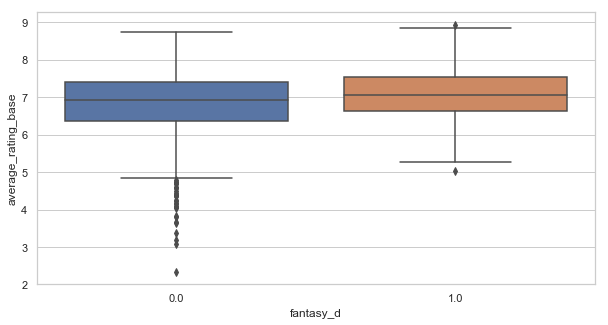

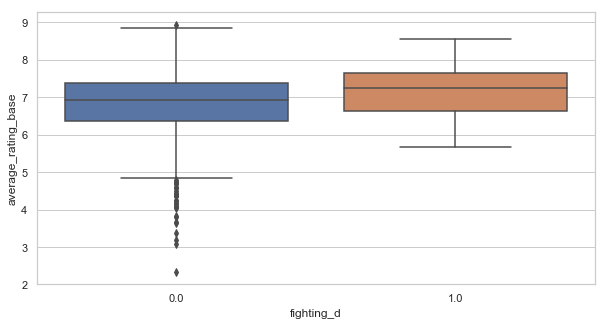

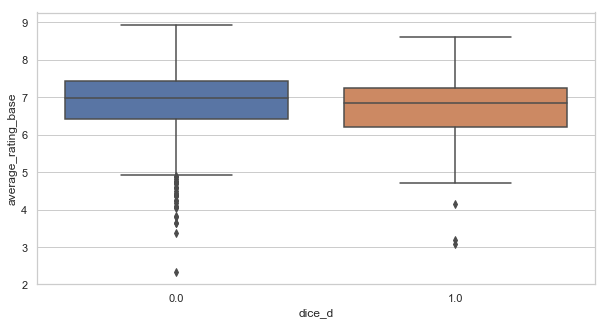

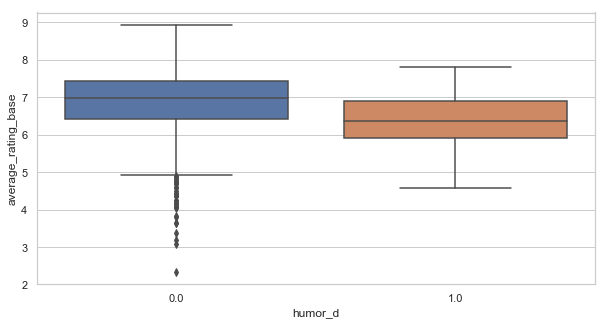

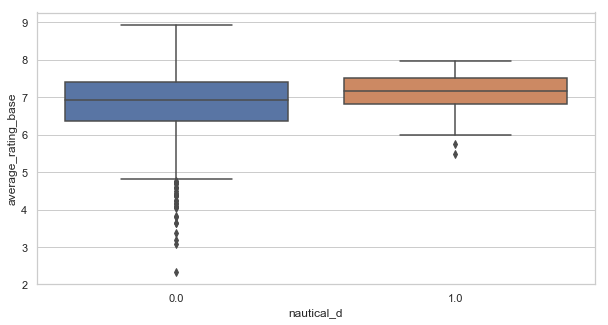

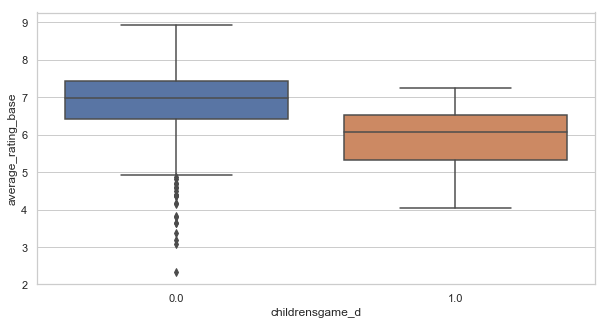

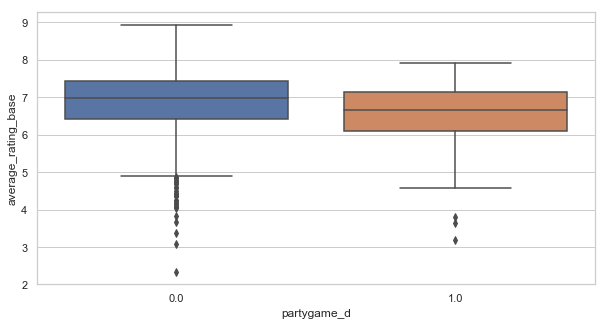

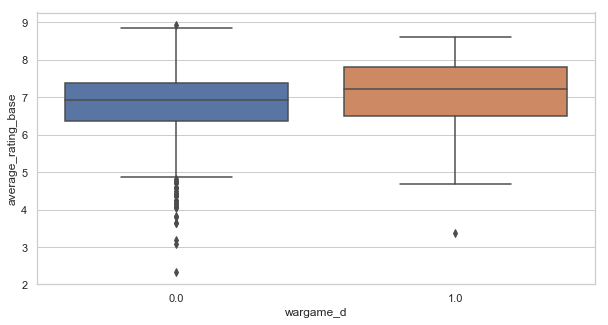

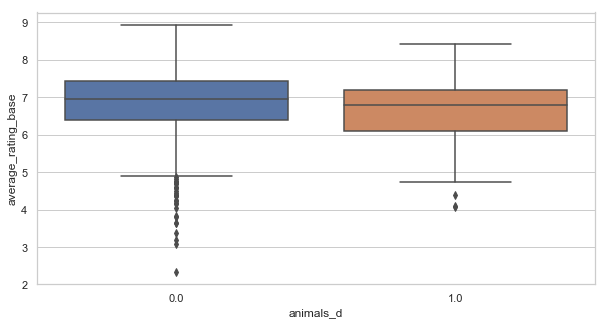

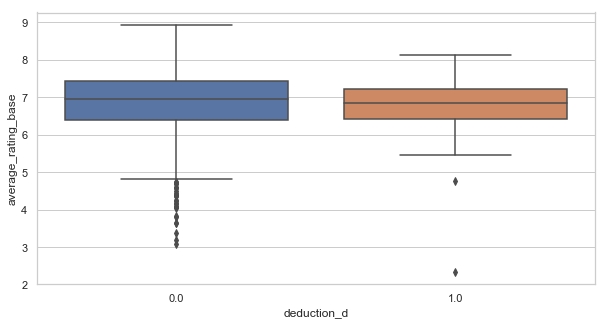

In [56]:
for x in categorical:   
    fig = sns.boxplot(data=board_games_short, x=x, y='average_rating_base')
    plt.show(fig)

## 5. Regression analysis

For the regression analysis we need to convert the categorical variables into dummies.

In [57]:
# Create dummies
board_games_short_year_dummies = pd.get_dummies(board_games_short['year_published_category_base'])
board_games_short_year_dummies.head()

,1951-1960,1961-1970,1971-1980,1981-1990,1991-2000,2001-2010,2011-2020
0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [58]:
# Create dummies
board_games_short_age_dummies = pd.get_dummies(board_games_short['min_age_category_base'])
board_games_short_age_dummies.head()

,0-7,8-12,13-17,18+
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0


In [59]:
board_games_short = pd.concat([board_games_short, board_games_short_year_dummies, board_games_short_age_dummies], axis=1)
board_games_short.head()

,max_players_base,max_playtime_base,min_players_base,average_rating_base,average_learning_complexity_api,average_strategy_complexity_api,min_age_category_base,year_published_category_base,users_rated_log_base,economic_d,negotiation_d,abstractstrategy_d,medieval_d,cardgame_d,sciencefiction_d,bluffing_d,citybuilding_d,adventure_d,fantasy_d,fighting_d,dice_d,humor_d,nautical_d,childrensgame_d,partygame_d,wargame_d,animals_d,deduction_d,1951-1960,1961-1970,1971-1980,1981-1990,1991-2000,2001-2010,2011-2020,0-7,8-12,13-17,18+
0,5,240,3,7.66508,0.000000,0.000000,13-17,1981-1990,8.411388,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0
1,4,60,2,7.44119,0.000000,0.000000,8-12,1991-2000,9.394244,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0
2,7,45,2,7.06751,2.000000,2.500000,13-17,1991-2000,10.252523,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1,0
3,4,120,3,7.26569,2.090909,2.545455,8-12,1991-2000,11.122177,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0
4,8,120,2,7.15355,0.000000,0.000000,8-12,1991-2000,9.871532,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0


For the regression analysis we used the **scikit learn** library and for the outputs we also used the **statsmodels**.

First, let's define the final predictor list which includes all the dummies created above.

In [60]:
# Import libraries
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define predictor list
x = board_games_short[[
    'max_players_base',                 
    'max_playtime_base',            
    #'min_age_base',                     
    'min_players_base',
    'average_learning_complexity_api',
    'average_strategy_complexity_api',
    # '1951-1960', # Reference
    '1961-1970',
    '1971-1980',
    '1981-1990',
    '1991-2000',
    '2001-2010',
    '2011-2020',
    # '0-7',
    '8-12',
    '13-17',
    '18+',
    'users_rated_log_base',          
    'economic_d',                        
    'negotiation_d',                      
    'abstractstrategy_d',                 
    'medieval_d',                         
    'cardgame_d',                         
    'sciencefiction_d',                   
    'bluffing_d',                         
    'citybuilding_d',                     
    'adventure_d',                        
    'fantasy_d',                          
    'fighting_d',                        
    'dice_d',                             
    'humor_d',                            
    'nautical_d',                         
    'childrensgame_d',                    
    'partygame_d',                    
    'wargame_d',                          
    'animals_d',                          
    'deduction_d']]

y = board_games_short[['average_rating_base']]

Let's fit a linear model using all of the predictors.

In [61]:
# Linear regression
ols = linear_model.LinearRegression()
ols.fit(x, y)

print(ols.intercept_)
print(ols.coef_)

[3.62840798]
[[-2.53038614e-02  3.76319372e-03  4.57580291e-02 -8.48512660e-02
   1.41135763e-01  1.31995214e-01  6.65003405e-01  6.63754451e-01
   9.92368812e-01  1.18906078e+00  1.65346332e+00  1.47307358e-01
   2.37714144e-01  8.62874933e-02  2.09859635e-01 -3.35961577e-02
  -4.46507590e-01  8.25013281e-02  1.62622643e-01 -1.09152942e-01
  -3.65936188e-02  3.99754932e-04  6.88816244e-02 -1.17214184e-01
   6.98939323e-02  1.01689615e-01 -2.27357220e-01 -3.34248241e-01
   3.69796195e-02 -1.21532490e-01  4.07150343e-02  1.05962327e-01
  -1.18166228e-01 -4.78567230e-02]]


We can get a nice summary of the regression output with the **statmodels** package.

In [62]:
import statsmodels.api as sm

# Add constant
xtrain_const = sm.add_constant(x)
est = sm.OLS(y, xtrain_const)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                            
Dep. Variable:     average_rating_base   R-squared:                       0.553
Model:                             OLS   Adj. R-squared:                  0.540
Method:                  Least Squares   F-statistic:                     43.72
Date:                 Sun, 27 Mar 2022   Prob (F-statistic):          9.23e-184
Time:                         22:30:01   Log-Likelihood:                -1070.5
No. Observations:                 1238   AIC:                             2211.
Df Residuals:                     1203   BIC:                             2390.
Df Model:                           34                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


C:\Users\User\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [63]:
* Complexity measures are strongly correlated, therefore we should keep one of them
* Exclude maximum players
* Number of minimum players is higher by one -> we can expect to have 0.15 higher ratings
* Compared to the games launched in the 50's games that were published in 


SyntaxError: invalid syntax (<ipython-input-63-01eda86a384a>, line 1)

In [ ]:
# Predict ratings

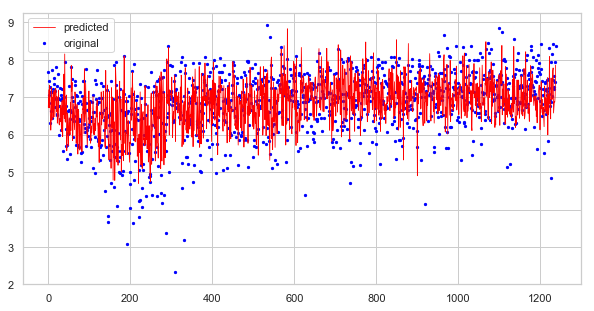

In [64]:
ypred = ols.predict(x)
x_ax = range(len(y))
plt.scatter(x_ax, y, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()